# Problem 4.1

In [2]:
'''
Things to note:

- Now we are using the skorch library which allows us to do parameter tunning in the same way as for
other classifiers in sklearn. 
- The code to add L1 regularization is already implemented.

'''

'\nThings to note:\n\n- Now we are using the skorch library which allows us to do parameter tunning in the same way as for\nother classifiers in sklearn. \n- The code to add L1 regularization is already implemented.\n\n'

In [3]:
# need to install skorch if you haven't done that
%pip install skorch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier
import skorch

# We need to import some Sci-kit Learn modules for computation purposes.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)


In [2]:
'''
Import the data
'''
# select the root = ....



mnist = torchvision.datasets.MNIST(root = './data', 
                                   train = True, 
                                   transform = transforms.ToTensor(),  
                                   download = True)

test_dataset = torchvision.datasets.MNIST(root = './data', 
                                          train = False, 
                                          transform = transforms.ToTensor(),
                                          download = True)


X_train = mnist.data
y_train = mnist.targets

X_test = test_dataset.data
y_test = test_dataset.targets


'''
Step -- Normalize each input from [0.0,1.0] range
'''
X_train = X_train.float()/255
X_test = X_test.float()/255

print(X_train.shape)
'''
Step -- Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''

X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)

print(X_train.shape)


torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


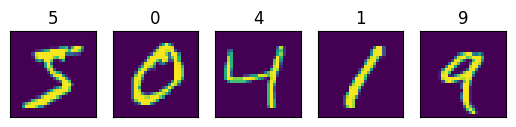

In [3]:

'''
Will do some basic plotting to get a feel for the data that we imported.

'''

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())
        
plot_example(X_train, y_train)

In [4]:
# build your CNN 
class CNN(nn.Module):
    def __init__(self, hidden_nodes=256, initialization=torch.nn.init.xavier_normal_ , num_channels=1, output_classes=10, dropout = 0.4, batchnorm = False):
        super(CNN, self).__init__()
        self.batchnorm = batchnorm
        self.hidden_nodes = hidden_nodes
        self.initialization = initialization
        '''Step -- Fill in the architecture'''
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=(5,5), bias=False)
        self.initialization(self.conv1.weight)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # Convolutional Layer 2
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), bias=False)
        self.initialization(self.conv2.weight)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        # Fully Connected Layer
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(in_features=32*4*4, out_features=256)
        self.initialization(self.fc1.weight)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # Output Layer
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features=self.hidden_nodes, out_features=output_classes)
        self.initialization(self.fc2.weight)
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        if self.batchnorm:
            x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        if self.batchnorm:
            x = self.batchnorm2(x)
        x = self.fc1(x.reshape(-1, 32*4*4))
        x = self.relu3(x)
        x = self.dropout(x)

        if self.batchnorm:
            x = self.batchnorm3(x)
        x = self.fc2(x)
        output = self.softmax(x)
        return output

In [5]:
# Adding L1 regularization

class RegularizedNet(NeuralNetClassifier):
    
    ''''''
    
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
    
    ''' *** Explain -- What is the following method doing? Explain in detail in the main pdf ***'''
    
    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred, y_true, X = X, training = training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [9]:
# print out the structure of the model 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [10]:
'''
Check Device == 'cuda'. USE GPU !!!!. Otherwise things will be super slow. Check
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d 
'''

print('Using Device = ',device)

Using Device =  cuda


In [16]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__<name of your parameter> = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNet(module = CNN, 
                    max_epochs = 100,
                    optimizer = torch.optim.SGD,
                    optimizer__momentum = 0.9,
                    lr = 0.025,
                    lambda1 = 0,
                    module__dropout = .4,
                    optimizer__weight_decay = .000001,
                    iterator_train__pin_memory = True,
                    iterator_valid__pin_memory = True,
                    device = device,
                    #callbacks = [skorch.callbacks.EarlyStopping('valid_acc', threshold = 0.001, patience = 10, threshold_mode='abs', lower_is_better=False)]
)
    

In [17]:
'''Step - train the network'''
cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Look how your loss is going down as well as the validation accuracy is increasing 
'''

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3734       0.9730        0.0928  1.4739
      2        0.0925       0.9814        0.0617  1.4216
      3        0.0626       0.9833        0.0551  1.4841
      4        0.0502       0.9849        0.0500  1.5181
      5        0.0408       0.9858        0.0470  1.4976
      6        0.0351       0.9862        0.0454  1.4804
      7        0.0319       0.9869        0.0424  1.5208
      8        0.0256       0.9867        0.0501  1.4678
      9        0.0246       0.9876        0.0439  1.6562
     10        0.0210       0.9892        0.0382  1.5258
     11        0.0201       0.9890        0.0367  1.4667
     12        0.0179       0.9884        0.0439  1.4776
     13        0.0168       0.9887        0.0390  1.4324
     14        0.0155       0.9902        0.0363  1.3047
     15        0.0133       0.9896        0.0426  1.3142
     16        0.0137       0.9

'\nLook how your loss is going down as well as the validation accuracy is increasing \n'

In [18]:
'''Step - Predict for the test set and print the final accuracy score, your validation accuracy obtained in the previous
cell should be similar to the accuracy in the test set
'''
print(cnn.history[-1, 'train_loss'])
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.0007808908046196876


0.9925

In [15]:
'''The idea is that you should get more than 98% of accuracy, so try different parameters as requested in the main pdf
The fit method is already showing you a validation error which can be used to compare between different parameters.

for the final submission leave the best parameters in your RegularizedNet(...)
'''
'''
Instead of doing it manually skorch allows us to use GridSearchCV from sklearn 
'''
from sklearn.model_selection import GridSearchCV

'''
Step - define a grid with some parameters that you consider may give you good results and 
the code will do the rest for you

* Especially take into account the parameters we are asking for to tune:  
Learning rate, regularization parameter, and the number of nodes

'''
# you can use cnn.get_params().keys() to get all the parameters that you can tune

grid = {
    'lr': [.025, .03],
    'max_epochs': [50],
    'criterion': [torch.nn.NLLLoss],
    'optimizer': [torch.optim.SGD],
    'lambda1': [0],
    'module__dropout': [.4],
    'module__hidden_nodes': [256, 300],
    'module__initialization': [torch.nn.init.xavier_normal_, torch.nn.init.xavier_uniform_],
    'optimizer__weight_decay': [0.0005, 0.0001, .00001],
    'optimizer__momentum': [0.7, 0.8, 0.9],
    'device': [device],
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=10)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6160       0.9264        0.2474  1.8270
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5910       0.9347        0.2053  1.9969
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6126       0.9479        0.1779  1.9831
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6110       0.9306        0.2129  2.0942
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6043       0.9453        0.1783  2.3656
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6058       0.9

/home/codygrogan/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codygrogan/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codygrogan/.local/lib/python3.11/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codygrogan/.local/lib/python3.11/site-

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3443       0.9722        0.0897  1.3712
      2        0.0947       0.9761        0.0763  1.6155
      3        0.0685       0.9836        0.0527  1.6260
      4        0.0518       0.9819        0.0535  1.5835
      5        0.0421       0.9868        0.0453  1.6825
      6        0.0356       0.9866        0.0428  1.3469
      7        0.0309       0.9877        0.0441  1.0461
      8        0.0279       0.9879        0.0400  1.5224
      9        0.0244       0.9886        0.0386  1.6546
     10        0.0223       0.9880        0.0404  1.6691
     11        0.0215       0.9884        0.0382  1.6539
     12        0.0191       0.9891        0.0407  1.6867
     13        0.0170       0.9888        0.0414  1.4623
     14        0.0166       0.9906        0.0366  1.3360
     15        0.0143       0.9903        0.0390  1.5841
     16        0.0130       0.9

# Problem 4.2

In [21]:
'''
Step - Now we are going to train the network with L1 regularization instead of L2 and dropout,
we are going to create a new network with a lambda1 parameter different than 0
- Keep the rest of the parameters you used in the previous network but dropout and L2 parameters are 0 
'''

cnn_l1 = RegularizedNet(module = CNN, 
                    max_epochs = 100,
                    optimizer = torch.optim.SGD,
                    optimizer__momentum = 0.9,
                    lr = 0.025,
                    lambda1 = 0.000001,
                    module__dropout = 0,
                    optimizer__weight_decay = 0,
                    iterator_train__pin_memory = True,
                    iterator_valid__pin_memory = True,
                    device = device,
                    #callbacks = [skorch.callbacks.EarlyStopping('valid_acc', threshold = 0.001, patience = 10, threshold_mode='abs', lower_is_better=False)]
)

In [22]:
#Refer to https://skorch.readthedocs.io/en/stable/user/save_load.html

import pickle

#Transfer Learning - 
#The following code will transfer the weights from L2 trained networks to initialize the new network before L1 training

'''

Notes - I assumed you have trained your L2 network using Skorch's NeuralNetClassifier
        I assume your trained model object is called "cnn"

'''

#Step - 1 - Save weights from L2 network

cnn.save_params(f_params='L2_cnn.pkl') # This comes after cnn.fit(). You are saving the model weights in a pickle


#Step - 2

cnn_l1.initialize()
cnn_l1.load_params(f_params='L2_cnn.pkl')



In [23]:
'''
Step train the network with the weights transfered from cnn, and perform grid search for the lambda1 parameter
'''

from sklearn.model_selection import GridSearchCV

grid = {
    'lr': [.025],
    'max_epochs': [50],
    'criterion': [torch.nn.NLLLoss],
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9],
    'lambda1': [0.000001, 0.00005, 0.00001],
    'module__dropout': [0],
    'optimizer__weight_decay': [0],
    'device': [device]
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=10)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

cnn_l1 = cnn_l1.set_params(**gs.best_params_)
cnn_l1.fit(X_train, y_train)

y_pred = cnn_l1.predict(X_test)
accuracy_score(y_test, y_pred)




  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4257       0.9656        0.1241  1.4527
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4591       0.9519        0.1630  1.7249
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4727       0.9565        0.1464  1.7613
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7163       0.9321        0.5211  2.0067
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7193       0.9565        0.4517  2.4249
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7509       0.9

0.9908

In [6]:
'''
Step train the network with default initialization parameters
we can simply initialize with the same code as before (make sure to use the same parameters)

perform grid search for the lambda1 parameter as in the previous cell
'''

cnn_l1 = RegularizedNet(module = CNN, 
                    max_epochs = 100,
                    optimizer = torch.optim.SGD,
                    optimizer__momentum = 0.9,
                    lr = 0.025,
                    lambda1 = 0.000001,
                    module__dropout = 0,
                    optimizer__weight_decay = 0,
                    iterator_train__pin_memory = True,
                    iterator_valid__pin_memory = True,
                    device = device,
                    callbacks = [skorch.callbacks.EarlyStopping('valid_acc', threshold = 0.001, patience = 10, threshold_mode='abs', lower_is_better=False)]
)

from sklearn.model_selection import GridSearchCV

grid = {
    'lr': [.025],
    'max_epochs': [50],
    'criterion': [torch.nn.NLLLoss],
    'optimizer': [torch.optim.SGD],
    'lambda1': [0.000001, 0.00005, 0.00001],
    'module__dropout': [0],
    'optimizer__weight_decay': [0],
    'device': [device]
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=-1)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

cnn_l1.fit(X_train, y_train)

y_pred = cnn_l1.predict(X_test)
accuracy_score(y_test, y_pred)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4529       0.9604        0.1296  1.6121
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4394       0.9507        0.1670  1.7347
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4354       0.9665        0.1250  1.5462
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7240       0.9464        0.4739  2.1535
      2        0.0990       0.9712        0.0954  2.1097
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7121       0.9688        0.4191  2.3510
      2        0.0924       0.9765        0.0837  2.2184
  epoch    train_loss    valid_

0.9927

# Problem 4.3

In [ ]:
'''
Keeping all the parameters for which you have got the best results before
try different optimizers.

Basically create the same cnn_l1 or new_net but train it with the requested optimizers in the pdf

GridSeacrh is not required but you can do it if you want for the different parameters of the optimizers

Notice you already train it with SGD in the previous problems
'''



In [7]:
# Adam (look how I defined optimizer)

cnn_l1_adam = RegularizedNet(module = CNN,
                            criterion=torch.nn.NLLLoss, 
                            optimizer = torch.optim.Adam, 
                            lr = 0.001, 
                            lambda1 = 0.000001,  
                            module__dropout = 0,
                            iterator_train__pin_memory = True,
                            iterator_valid__pin_memory = True,
                            optimizer__weight_decay = 0, 
                            max_epochs = 100, 
                            device = device)

'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_l1_adam.fit(X_train, y_train)

y_pred = cnn_l1_adam.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2924       0.9722        0.0998  1.3923
      2        0.0743       0.9829        0.0651  1.6255
      3        0.0524       0.9864        0.0536  1.4255
      4        0.0402       0.9867        0.0532  1.5635
      5        0.0326       0.9871        0.0509  1.4761
      6        0.0277       0.9854        0.0535  1.4160
      7        0.0246       0.9848        0.0577  1.3720
      8        0.0234       0.9830        0.0687  1.5527
      9        0.0212       0.9848        0.0645  1.2607
     10        0.0187       0.9841        0.0715  1.2961
     11        0.0173       0.9875        0.0586  1.2811
     12        0.0144       0.9855        0.0741  1.6296
     13        0.0164       0.9878        0.0632  1.6588
     14        0.0142       0.9882        0.0615  1.6914
     15        0.0145       0.9865        0.0712  1.3739
     16        0.0151       0.9

0.9928

In [8]:
# SGD standard 
cnn_l1_sgd = RegularizedNet(module = CNN, 
                            criterion=torch.nn.NLLLoss, 
                            optimizer = torch.optim.SGD, 
                            lr = 0.025, 
                            lambda1 = 0.000001,  
                            module__dropout = 0,
                            iterator_train__pin_memory = True,
                            iterator_valid__pin_memory = True,
                            optimizer__weight_decay = 0, 
                            max_epochs = 100, 
                            device = device
                            )

'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_l1_sgd.fit(X_train, y_train)

y_pred = cnn_l1_sgd.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7752       0.9166        0.2786  1.6331


      2        0.1961       0.9457        0.1834  1.2037
      3        0.1356       0.9600        0.1418  1.5272
      4        0.1089       0.9660        0.1193  1.7022
      5        0.0930       0.9699        0.1049  1.5534
      6        0.0821       0.9726        0.0955  1.2223
      7        0.0741       0.9754        0.0886  1.4348
      8        0.0679       0.9762        0.0843  1.5794
      9        0.0628       0.9782        0.0803  1.3438
     10        0.0584       0.9796        0.0771  1.5379
     11        0.0548       0.9809        0.0738  1.5767
     12        0.0515       0.9812        0.0713  1.5982
     13        0.0487       0.9816        0.0691  1.4473
     14        0.0461       0.9821        0.0670  1.5831
     15        0.0438       0.9823        0.0650  1.3581
     16        0.0417       0.9825        0.0636  1.4303
     17        0.0398       0.9829        0.0623  1.2396
     18        0.0380       0.9832        0.0612  1.2903
     19        0.0363       0.9

0.9893

In [9]:
# SGD with momentum 
cnn_l1_sgd_mom = RegularizedNet(module = CNN, 
                                criterion=torch.nn.NLLLoss, 
                                optimizer = torch.optim.SGD, 
                                lr = 0.025, 
                                lambda1 = 0.000001,  
                                module__dropout = 0,
                                optimizer__weight_decay = 0, 
                                max_epochs = 100, 
                                device = device, 
                                optimizer__momentum = .9)

'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_l1_sgd_mom.fit(X_train, y_train)

y_pred = cnn_l1_sgd_mom.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3530       0.9727        0.0980  0.8720
      2        0.0700       0.9818        0.0682  0.8807
      3        0.0484       0.9848        0.0605  0.9153
      4        0.0375       0.9858        0.0578  0.9034
      5        0.0307       0.9847        0.0587  0.9153
      6        0.0262       0.9855        0.0586  0.8278
      7        0.0226       0.9845        0.0638  0.8203
      8        0.0196       0.9840        0.0675  0.8091
      9        0.0175       0.9842        0.0718  0.8110
     10        0.0163       0.9828        0.0817  0.8083
     11        0.0148       0.9838        0.0740  0.8369
     12        0.0135       0.9869        0.0636  0.8489
     13        0.0125       0.9867        0.0653  0.8510
     14        0.0106       0.9868        0.0693  0.8564
     15        0.0101       0.9861        0.0738  0.8579
     16        0.0099       0.9

0.9919

In [10]:
# AdaGrad
cnn_l1_ada = RegularizedNet(module = CNN, 
                            criterion=torch.nn.NLLLoss, 
                            optimizer = torch.optim.Adagrad, 
                            lr = 0.025, 
                            lambda1 = 0.000001,  
                            module__dropout = 0,
                            optimizer__weight_decay = 0, 
                            max_epochs = 100, 
                            device = device)


'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_l1_ada.fit(X_train, y_train)

y_pred = cnn_l1_ada.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2782       0.9676        0.1112  0.8918
      2        0.0586       0.9809        0.0661  0.8869


      3        0.0427       0.9848        0.0552  0.8870
      4        0.0343       0.9870        0.0508  0.8514
      5        0.0289       0.9882        0.0489  0.8224
      6        0.0250       0.9885        0.0480  0.8479
      7        0.0219       0.9888        0.0473  0.8863
      8        0.0195       0.9888        0.0472  0.8861
      9        0.0175       0.9890        0.0475  0.8882
     10        0.0159       0.9893        0.0479  0.8835
     11        0.0145       0.9894        0.0485  0.8867
     12        0.0133       0.9893        0.0492  0.8891
     13        0.0123       0.9896        0.0499  0.8893
     14        0.0115       0.9895        0.0506  0.8878
     15        0.0108       0.9895        0.0513  0.8900
     16        0.0103       0.9894        0.0520  0.8475
     17        0.0098       0.9893        0.0524  0.8206
     18        0.0094       0.9895        0.0529  0.8239
     19        0.0090       0.9895        0.0533  0.8227
     20        0.0087       0.9

0.9901

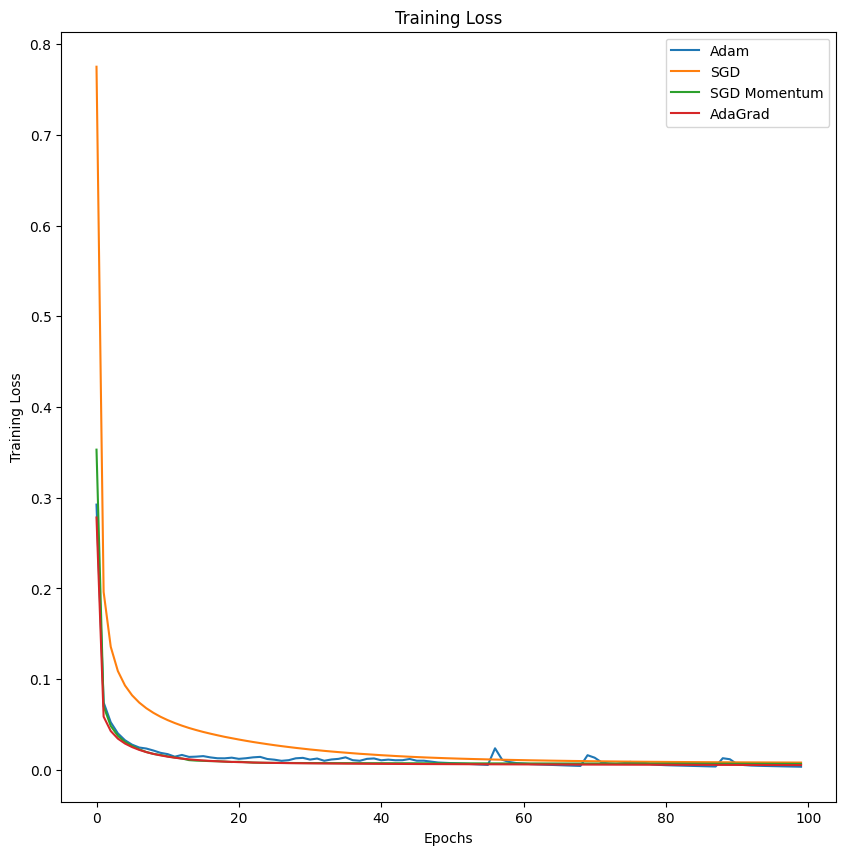

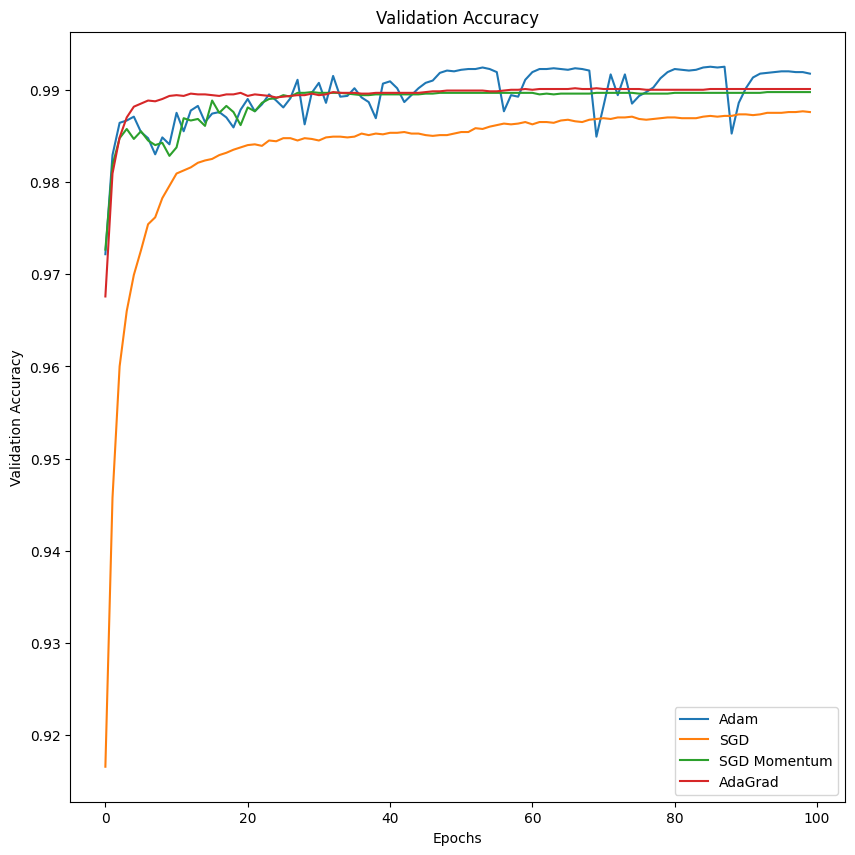

In [11]:
## Plotting

# Plotting training loss
fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.plot(cnn_l1_adam.history[:, 'train_loss'], label = 'Adam')
ax.plot(cnn_l1_sgd.history[:, 'train_loss'], label = 'SGD')
ax.plot(cnn_l1_sgd_mom.history[:, 'train_loss'], label = 'SGD Momentum')
ax.plot(cnn_l1_ada.history[:, 'train_loss'], label = 'AdaGrad')

ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend()

# Plotting validation accuracy

fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.plot(cnn_l1_adam.history[:, 'valid_acc'], label = 'Adam')
ax.plot(cnn_l1_sgd.history[:, 'valid_acc'], label = 'SGD')
ax.plot(cnn_l1_sgd_mom.history[:, 'valid_acc'], label = 'SGD Momentum')
ax.plot(cnn_l1_ada.history[:, 'valid_acc'], label = 'AdaGrad')

ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy')
ax.legend()


In [15]:
# Batch Normalization

cnn_l1_batch_norm = RegularizedNet(module = CNN, 
                                   criterion=torch.nn.NLLLoss, 
                                    optimizer = torch.optim.Adam, 
                                    lr = 0.0001, 
                                    lambda1 = 0.000001,  
                                    module__dropout = 0, 
                                    module__batchnorm = True,
                                    optimizer__weight_decay = 0, 
                                    max_epochs = 100, 
                                    device = device)


cnn_l1_batch_norm.fit(X_train, y_train)

y_pred = cnn_l1_batch_norm.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4506       0.9549        0.1690  0.9801
      2        0.1270       0.9707        0.1110  0.9016
      3        0.0847       0.9762        0.0878  0.8690
      4        0.0638       0.9810        0.0752  0.9286
      5        0.0507       0.9830        0.0675  0.9564
      6        0.0414       0.9838        0.0623  0.9033
      7        0.0344       0.9847        0.0585  0.9145
      8        0.0289       0.9858        0.0556  0.8698
      9        0.0244       0.9859        0.0534  0.8933
     10        0.0207       0.9867        0.0517  0.9036
     11        0.0177       0.9872        0.0505  0.9473
     12        0.0153       0.9874        0.0495  0.9390
     13        0.0134       0.9875        0.0488  0.9129
     14        0.0119       0.9874        0.0483  0.9142
     15        0.0108       0.9874        0.0479  0.9214
     16        0.0099       0.9

0.9913